In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

2022-11-17 09:52:58.111547: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-17 09:52:58.114155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 09:52:58.114164: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
# tf.test.is_gpu_available()
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


2022-11-17 09:52:59.298434: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-17 09:52:59.298454: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl56): /proc/driver/nvidia/version does not exist


In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2022-11-17 09:52:59.313270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
from pprint import pprint
# print(info)
# print(info.splits)
pprint(info.splits)

{'test': <SplitInfo num_examples=3669, num_shards=4>,
 'train': <SplitInfo num_examples=3680, num_shards=4>}


In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [7]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [53]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print("STEPS_PER_EPOCH : ", STEPS_PER_EPOCH)

STEPS_PER_EPOCH :  57


In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


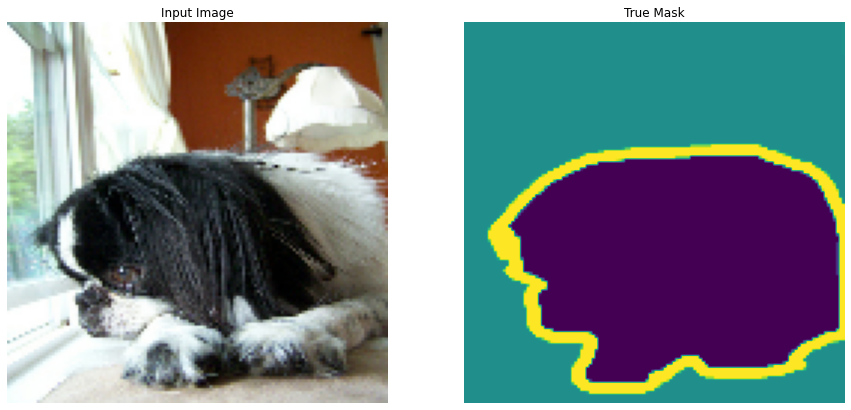

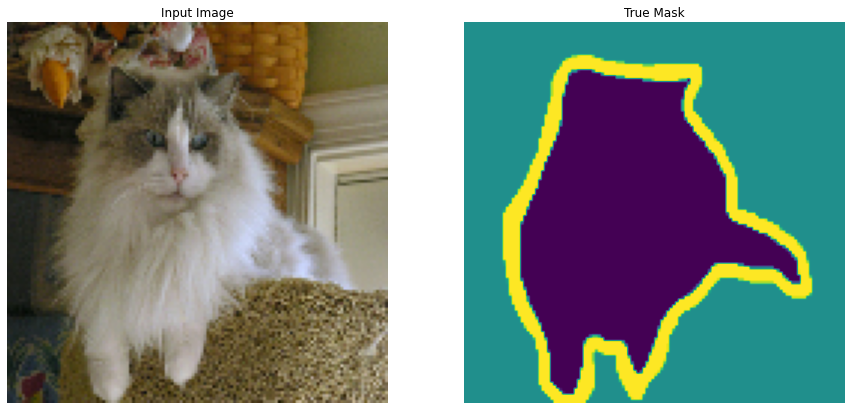

2022-11-17 09:53:00.316105: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9406464/9406464 [==============================] - 2s 0us/step


In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [20]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 0s 423ms/step


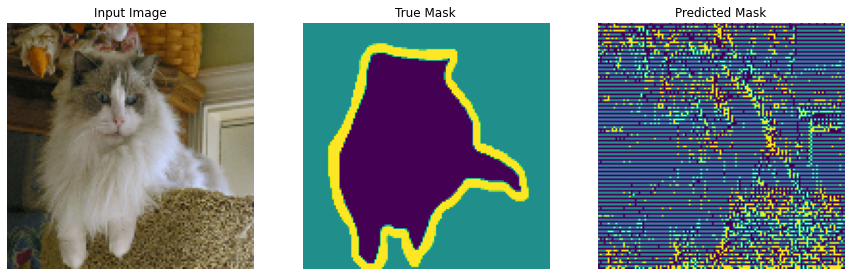

In [21]:
show_predictions()

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        clear_output(wait=False)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))


1/1 [==============================] - 0s 24ms/step


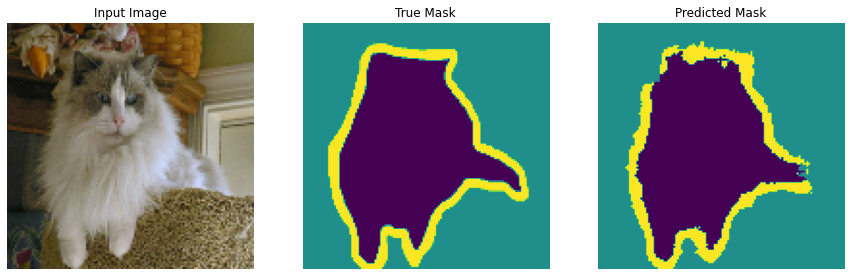


Sample Prediction after epoch 20

57/57 [==============================] - 46s 813ms/step - loss: 0.1814 - accuracy: 0.9194 - val_loss: 0.2875 - val_accuracy: 0.8894


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


In [24]:
model

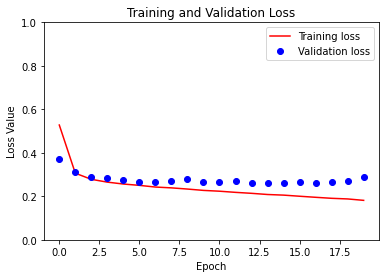

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 0s 193ms/step


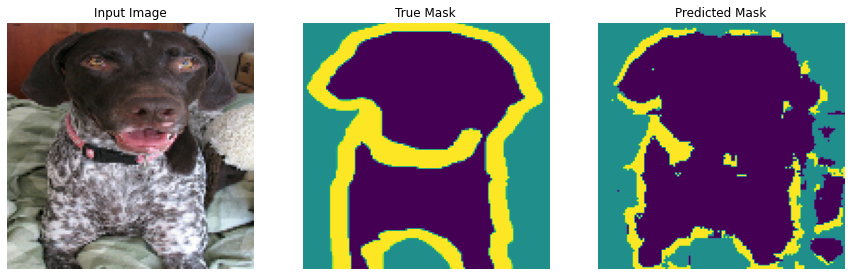

In [26]:
show_predictions(test_batches, 10)

In [27]:
try:
    model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
    assert False
    
except Exception as e:
    print(f"Expected {type(e).__name__}: {e}")


Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


In [28]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()


array([ 3.0485873, 30.485874 ], dtype=float32)

In [29]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights


In [30]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [31]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])


In [32]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=10,
    steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 9s 744ms/step - loss: 0.2712 - accuracy: 0.6502
Epoch 2/10
10/10 [==============================] - 7s 726ms/step - loss: 0.1507 - accuracy: 0.8278
Epoch 3/10
10/10 [==============================] - 7s 723ms/step - loss: 0.1147 - accuracy: 0.8660
Epoch 4/10
10/10 [==============================] - 7s 723ms/step - loss: 0.0926 - accuracy: 0.8739
Epoch 5/10
10/10 [==============================] - 7s 728ms/step - loss: 0.0827 - accuracy: 0.8816
Epoch 6/10
10/10 [==============================] - 7s 676ms/step - loss: 0.0755 - accuracy: 0.8847
Epoch 7/10
10/10 [==============================] - 7s 725ms/step - loss: 0.0706 - accuracy: 0.8892
Epoch 8/10
10/10 [==============================] - 7s 724ms/step - loss: 0.0664 - accuracy: 0.8951
Epoch 9/10
10/10 [==============================] - 7s 715ms/step - loss: 0.0643 - accuracy: 0.8965
Epoch 10/10
10/10 [==============================] - 7s 722ms/step - loss: 0.0611 - accuracy: 0.9024

In [33]:
# dir(weighted_model)
# dir(weighted_model.history)
# dir(weighted_model.history.history)
weighted_model.history.history

{'loss': [0.27118903398513794,
  0.15069271624088287,
  0.11466914415359497,
  0.09258012473583221,
  0.08271043002605438,
  0.07545903325080872,
  0.07062133401632309,
  0.06635842472314835,
  0.06425740569829941,
  0.06108599901199341],
 'accuracy': [0.6502412557601929,
  0.827806830406189,
  0.8659681081771851,
  0.8739184141159058,
  0.8815816640853882,
  0.88467937707901,
  0.8891501426696777,
  0.8950832486152649,
  0.8964683413505554,
  0.9024417996406555]}

In [34]:
# loss = weighted_model.history.history['loss']
# accuracy = weighted_model.history.history['accuracy']

# plt.figure()
# plt.plot(weighted_model.history.epoch, loss, 'r', label='Training loss')
# plt.plot(weighted_model.history.epoch, accuracy, 'bo', label='Training accuracy')
# plt.title('Training loss vs  Training accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Training loss vs accuracy')
# plt.ylim([0 , 1])
# plt.legend()
# plt.show()

In [35]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = weighted_model.evaluate(test_batches)

Evaluate on test data
58/58 [==============================] - 25s 416ms/step - loss: 0.2941 - accuracy: 0.8799


In [36]:
print(dict(zip(weighted_model.metrics_names, results)))

{'loss': 0.29412248730659485, 'accuracy': 0.8799054622650146}


In [37]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [38]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=20,
    steps_per_epoch=10)

Epoch 1/20
10/10 [==============================] - 8s 631ms/step - loss: 0.3268 - accuracy: 0.6052
Epoch 2/20
10/10 [==============================] - 6s 639ms/step - loss: 0.1464 - accuracy: 0.8487
Epoch 3/20
10/10 [==============================] - 7s 701ms/step - loss: 0.1112 - accuracy: 0.8678
Epoch 4/20
10/10 [==============================] - 7s 703ms/step - loss: 0.0906 - accuracy: 0.8771
Epoch 5/20
10/10 [==============================] - 7s 703ms/step - loss: 0.0785 - accuracy: 0.8839
Epoch 6/20
10/10 [==============================] - 7s 658ms/step - loss: 0.0742 - accuracy: 0.8870
Epoch 7/20
10/10 [==============================] - 7s 714ms/step - loss: 0.0673 - accuracy: 0.8946
Epoch 8/20
10/10 [==============================] - 7s 701ms/step - loss: 0.0649 - accuracy: 0.8971
Epoch 9/20
10/10 [==============================] - 7s 705ms/step - loss: 0.0614 - accuracy: 0.9021
Epoch 10/20
10/10 [==============================] - 7s 700ms/step - loss: 0.0609 - accuracy: 0.9018

In [47]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data After 20 epoch training")
results = weighted_model.evaluate(test_batches)

Evaluate on test data After 20 epoch training
58/58 [==============================] - 22s 386ms/step - loss: 0.2880 - accuracy: 0.8846


# References

- https://www.tensorflow.org/tutorials/images/segmentation